<a href="https://colab.research.google.com/github/claree007/Housing-Prices/blob/master/Housing_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>California Housing Prices</h1>

This is a regression problem which I have tackled using different ML models and here I compare their training time and accuracy. I have used Scikit-Learn and TensorFlow.




In [0]:
import os
import time
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.svm import LinearSVR
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin

<h2>Loading the dataset</h2>

The dataset is already split into train and test set but it is the ratio 1:1. So I combine the 2 sets and then divide the whole set into train and test sets in the ratio 80 : 20 and then split the training set to make validation set in the ratio 20 : 80. The dataset is already clean and ready to train.

In [2]:
HOUSING_PATH = "sample_data"

def load_housing_data(file_name, housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, file_name)
    return pd.read_csv(csv_path)


housing_set1 = load_housing_data(file_name="california_housing_train.csv")
housing_set2 = load_housing_data(file_name="california_housing_test.csv")

housing = pd.concat([housing_set1, housing_set2], axis=0, ignore_index=True)

housing_X = housing.drop("median_house_value", axis=1)
housing_y = housing["median_house_value"].copy()

X_train_whole, X_test, y_train_whole, y_test = train_test_split(housing_X, housing_y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_whole, y_train_whole, test_size=0.2)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

#housing.head()

Training set size: (12800, 8)
Validation set size: (3200, 8)
Test set size: (4000, 8)


Some visualizations of the dataset.

In [0]:
#housing.hist(bins=50, figsize=(20, 15))
#plt.show()

correlation = housing.corr()
correlation["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.689109
total_rooms           0.135298
housing_median_age    0.104470
households            0.066573
total_bedrooms        0.051111
population           -0.024234
longitude            -0.045788
latitude             -0.143969
Name: median_house_value, dtype: float64

<h2>Preparing the dataset</h2>

In [0]:
class AddBias(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, Y=None):
        return np.c_[np.ones((X.shape[0], 1)), X]


lin_reg_pipeline = Pipeline([
    ("std_scaler", StandardScaler()),
    ("bias_adder", AddBias()),
])

# standardize and add bias to training set
X_train_bias = lin_reg_pipeline.fit_transform(X_train)

# standardize and add bias to validation set
X_val_bias = lin_reg_pipeline.transform(X_val)


# to prevent some error
y_train = y_train.ravel().reshape(y_train.shape[0], 1)
y_val = y_val.ravel().reshape(y_val.shape[0], 1)

<h2>Training</h2>

For each model, the best hyperparameters will searched and used. The accuracy of each model during training is testd against a validation set.

In [0]:
def rmse_error(y_train, y_train_predict, y_val, y_val_predict):
    '''
    for i in range(len(y_train)):
        train_error.append(mean_squared_error(y_train.iloc[:i+1], y_train_predict[:i+1]))
    for i in range(len(y_val)):
        val_error.append(mean_squared_error(y_val.iloc[:i+1], y_val_predict[:i+1]))
    '''
    train_error = np.sqrt(mean_squared_error(y_train, y_train_predict))
    val_error = np.sqrt(mean_squared_error(y_val.ravel(), y_val_predict))
    return train_error, val_error
    '''
    plt.plot(np.sqrt(train_error), "b-", linewidth=2, label="train")
    plt.plot(np.sqrt(val_error), "r-", linewidth=2, label="validation")
    plt.legend()
    '''

def cross_validation_score(model, X, y):
    return cross_val_score(model, X, y, cv=10)
    
def learning_curve(model, X_train, y_train, X_val, y_val):
    train_error = []
    val_error = []
    m_train = len(X_train)
    m_val = len(X_val)
    
    if m_val <= m_train:
        m = m_val
    else:
        m = m_train
        
    for i in range(10, m+1):
        model.fit(X_train[:i], y_train[:i])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_error.append(mean_squared_error(y_train[:m], y_train_predict))
        val_error.append(mean_squared_error(y_val, y_val_predict))
        #plt.plot(np.sqrt(train_error), "b-", linewidth=3, label="train")
        #plt.plot(np.sqrt(val_error), "r-", label="val")
        
    plt.plot(np.sqrt(train_error), "b-", linewidth=3, label="train")
    plt.plot(np.sqrt(val_error), "r-", label="val")
    plt.legend()
    plt.show()
    
    
def train_model(model, X_train, y_train, X_val, y_val):
    print(type(model).__name__)
    start = time.time()
    print(y_train.shape)
    model.fit(X_train, y_train)
    end = time.time()
    
    y_train_predict = model.predict(X_train)
    y_val_predict = model.predict(X_val)

    print(rmse_error(y_train, y_train_predict, y_val, y_val_predict))

    #scores = cross_validation_score(model, X_train_whole, y_train_whole)
    #print("Accuracy: {0:2.2f} +/- {1:2.2f}".format(scores.mean(), scores.std()))
    print("Time taken: {0:2.5f} seconds".format(end-start))
    print('\n\n\n')

<h3>Linear Regression</h3>

1. SVD

In [0]:
lin_reg = LinearRegression()
#learning_curve(lin_reg, X_train_bias, y_train, X_val_bias, y_val)
train_model(lin_reg, X_train, y_train, X_val, y_val)

theta_best = np.linalg.inv(X_train_bias.T.dot(X_train_bias)).dot(X_train_bias.T).dot(y_train)

y_train_predict = X_train_bias.dot(theta_best)

# making predictions

y_val_predict = X_val_bias.dot(theta_best)

print(rmse_error(y_train, y_train_predict, y_val, y_val_predict))


LinearRegression
(12800,)
(69169.77008973308, 71641.4207119384)
Time taken: 0.01253 seconds
(69169.77008973307, 71641.42071194034)


2. Batch Gradient Descent

In [0]:
class BatchGradientDescent(BaseEstimator, RegressorMixin):
    def __init__(self, lr=0.01, n_iterations=10):
        self.lr = lr
        self.n_iterations = n_iterations
        self.intercept_ = None
        self.coef_ = None
        self.theta = None
        self.cost = np.array([])
        
    def gradient_descent(self, X, y, theta):
        m = X.shape[0]
        for iteration in range(self.n_iterations):
            print(iteration)
            #print(X.dot(theta).shape, y.shape)
            err = np.subtract(X.dot(theta), y)
            #print(err.values)
            self.cost = np.append(self.cost, (1 / (2 * m)) * np.sum(np.square(err)))
            gradient = (1 / m) * (X.T.dot(err))
            theta = theta - (self.lr * gradient)
        return theta
        
    def fit(self, X, y=None, theta=None):
        print(type(y))
        if theta == None:
            self.theta = np.random.randn(X.shape[1], 1)
        else:
            self.theta = theta
        self.theta = self.gradient_descent(X, y, self.theta)
        self.intercept_ = self.theta[0]
        self.coef_ = self.theta[1:]
        
    def predict(self, X):
        try:
            if self.theta:
                return X.dot(self.theta)
        except Exception as e:
            print(e)
            if self.theta.any() == False:
                return X.dot(self.theta)
        else:
            return "Run the fit method first"
        
        
bgd = BatchGradientDescent()
#learning_curve(lin_reg, X_train, y_train, X_val, y_val)
train_model(bgd, X_train_bias, y_train, X_val_bias, y_val)
        
'''
lr = 0.3
n_iterations = 150
m = X_train.shape[0]

theta = np.random.randn(X_train.shape[1]+1, 1)
cost = np.array([])

#print(X_train_bias.dot(theta))

for iteration in range(n_iterations):
    #print(X_train_bias.dot(theta))
    #print(iteration,)
    #y_train.reshape = (-1, 1)
    y_train.values.shape = (y_train.shape[0], 1)
    err = np.subtract(X_train_bias.dot(theta), y_train.values)
    #print(X_train_bias.dot(theta).shape, y_train.shape, err.shape)
    cost = np.append(cost, (1 / (2 * m)) * np.sum(np.square(err)))
    #print("cost:", cost[iteration])
    gradient = (1 / m) * (X_train_bias.T.dot(err))
    #print("gradient:", gradient)
    #print(X_train_bias.T.shape, err.shape, (X_train_bias.T.dot(err)).shape)
    theta = theta - (lr * gradient)
    #print("theta:", theta)
    
plt.plot(np.arange(1, n_iterations + 1), cost, "b-", label="cost function")
plt.xlabel("no of iterations")
plt.ylabel("cost")
plt.show()

y_train_predict = X_train_bias.dot(theta)
y_val_predict = X_val_bias.dot(theta)
#print(y_train.values, y_train_predict)
rmse_error(y_train.values, y_train_predict, y_val.values, y_val_predict)
'''

3. Stochastic Gradient Descent

In [0]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.03)
sgd_reg.fit(X_train_bias, y_train.ravel())

y_train_predict = sgd_reg.predict(X_train_bias)
y_val_predict = sgd_reg.predict(X_val_bias)

rmse_error(y_train, y_train_predict, y_val, y_val_predict)

4. Ridge Regression

In [0]:
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X_train, y_train.ravel())

y_train_predict = ridge_reg.predict(X_train)
y_val_predict = ridge_reg.predict(X_val)

rmse_error(y_train, y_train_predict, y_val, y_val_predict)

(69379.79717275512, 70324.05568626848)

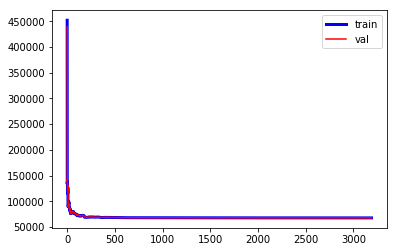

LinearRegression
(12800, 1)
(69783.82125823473, 67970.1683880426)
Time taken: 0.01530 seconds






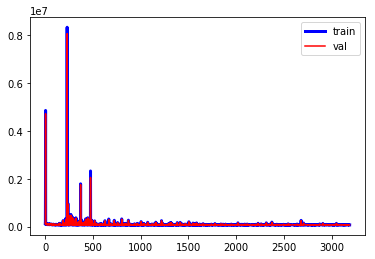

SGDRegressor
(12800, 1)
(71987.45895235546, 70159.51073616097)
Time taken: 0.04037 seconds






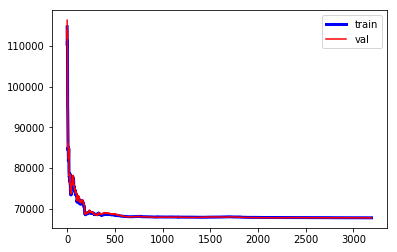

Ridge
(12800, 1)
(69783.83528839216, 67971.45999747956)
Time taken: 0.00468 seconds






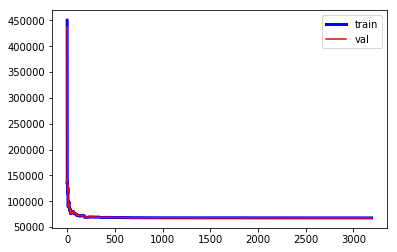

Lasso
(12800, 1)
(69783.82179969696, 67970.30857934312)
Time taken: 0.04791 seconds






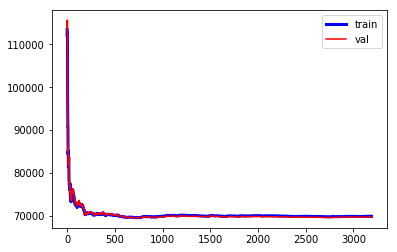

ElasticNet
(12800, 1)
(71484.11857828048, 70037.00898201863)
Time taken: 0.02843 seconds






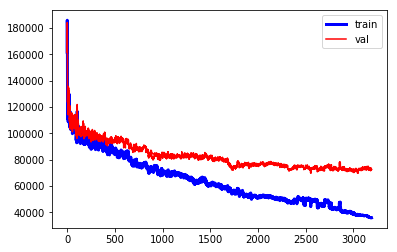

DecisionTreeRegressor
(12800, 1)
(46039.33893542222, 67244.18574896778)
Time taken: 0.09559 seconds






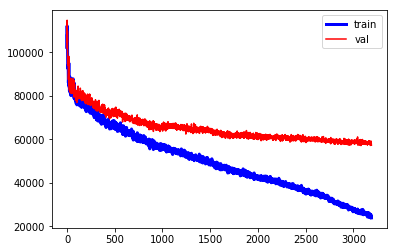

RandomForestRegressor
(12800, 1)
(22292.570672308004, 53138.228414390906)
Time taken: 0.83110 seconds






In [13]:
lin_reg = LinearRegression()
#bgd = BatchGradientDescent()
sgd_reg = SGDRegressor(max_iter=50000, tol=1e-3, penalty=None, eta0=0.3)
ridge_reg = Ridge(alpha=1, solver="cholesky")
lasso_reg = Lasso(alpha=1)
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
svm_reg = LinearSVR(epsilon=1.5)
dt_reg = DecisionTreeRegressor(max_depth=10)
rf_reg = RandomForestRegressor(n_estimators=10)

#####   save these as tuple of(model, bool for whether ravel is needed)   ######
models = [lin_reg, sgd_reg, ridge_reg, lasso_reg, elastic_net, dt_reg, rf_reg]

###############   grid search   #####################

warnings.simplefilter("ignore")
for model in models:
    learning_curve(model, X_train_bias, y_train.ravel(), X_val_bias, y_val.ravel())
    train_model(model, X_train_bias, y_train, X_val_bias, y_val)

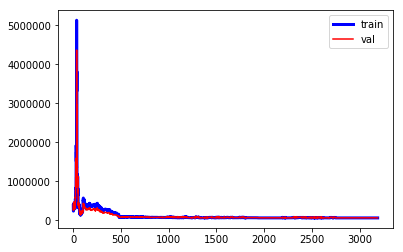

LinearRegression
(12800, 1)
(63283.52162502859, 62293.26374365892)
Time taken: 0.03397 seconds






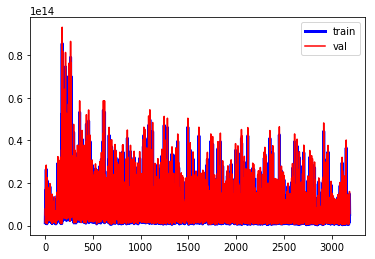

SGDRegressor
(12800, 1)
(14445956867186.377, 2691402125030.037)
Time taken: 0.11139 seconds






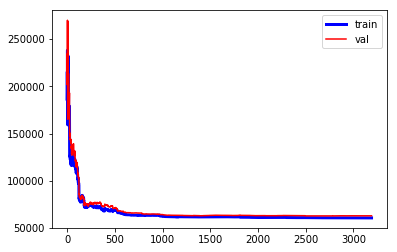

Ridge
(12800, 1)
(63284.2669891772, 62277.66262678806)
Time taken: 0.01934 seconds






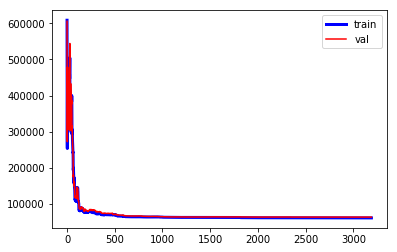

Lasso
(12800, 1)
(63325.69451391317, 62255.82266376388)
Time taken: 0.72455 seconds






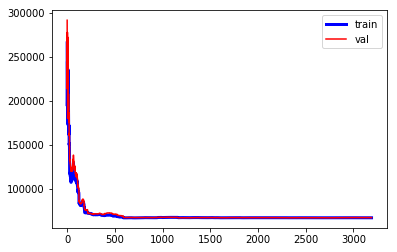

ElasticNet
(12800, 1)
(68283.3922596871, 67001.2926630841)
Time taken: 0.89165 seconds






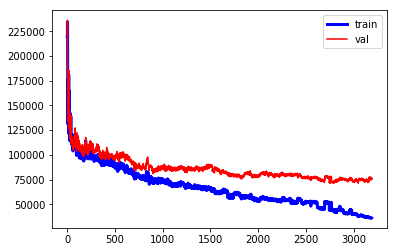

DecisionTreeRegressor
(12800, 1)
(46022.66015465455, 66114.30047997792)
Time taken: 0.51886 seconds






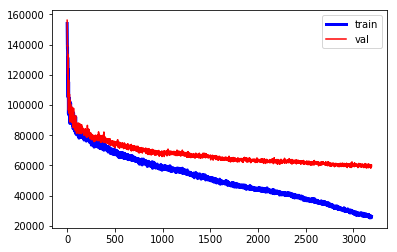

RandomForestRegressor
(12800, 1)
(22266.957767411626, 53190.41162686147)
Time taken: 4.81147 seconds






In [16]:
poly_reg_pipeline = Pipeline([
    ("std_scaler", StandardScaler()),
    ("poly_features", PolynomialFeatures(degree=2, include_bias="False")),
    ("bias_adder", AddBias()),
])

#poly_features = PolynomialFeatures(degree=2, include_bias="False")
X_train_bias = poly_reg_pipeline.fit_transform(X_train)
X_val_bias = poly_reg_pipeline.transform(X_val)

models = [lin_reg, sgd_reg, ridge_reg, lasso_reg, elastic_net, dt_reg, rf_reg]

warnings.simplefilter("ignore")

for model in models:
    learning_curve(model, X_train_bias, y_train.ravel(), X_val_bias, y_val.ravel())
    train_model(model, X_train_bias, y_train, X_val_bias, y_val)

5. Lasso Regression

In [0]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train, y_train.ravel())

learning_curve(lasso_reg, X_train_bias, y_train, X_val_bias, y_val)
train_model(lasso_reg, X_train_bias, y_train, X_val_bias, y_val)

#y_train_predict = lasso_reg.predict(X_train)
#y_val_predict = lasso_reg.predict(X_val)

#rmse_error(y_train, y_train_predict, y_val, y_val_predict)

6. Elastic Net

In [0]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X_train, y_train.ravel())

y_train_predict = elastic_net.predict(X_train)
y_val_predict = elastic_net.predict(X_val)

rmse_error(y_train.values, y_train_predict, y_val.values, y_val_predict)

(69766.89780642367, 70718.68878580334)

7. Polynomial Features

In [0]:
poly_features = PolynomialFeatures(degree=2, include_bias="False")
X_train_poly = poly_features.fit_transform(X_train)
X_val_poly = poly_features.transform(X_val)

lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, y_train.ravel())

y_train_predict = lin_reg.predict(X_train_poly)
y_val_predict = lin_reg.predict(X_val_poly)

rmse_error(y_train.values, y_train_predict, y_val.values, y_val_predict)

(62977.433474078956, 65122.43232757863)

In [0]:
#dt_reg = DecisionTreeRegressor(max_depth=10)
#train_model(dt_reg, X_train_bias, y_train, X_val_bias, y_val)

rf_reg = RandomForestRegressor(n_estimators=100)
train_model(rf_reg, X_train_bias, y_train.ravel(), X_val_bias, y_val.ravel())

RandomForestRegressor
(12800,)
(18664.50601247451, 51955.05447459563)
Time taken: 8.13975 seconds


In [0]:
rooms_ind, bedrooms_ind, population_ind, households_ind = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ind] / X[:, households_ind]
        population_per_household = X[:, population_ind] / X[:, households_ind]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ind] / X[:, rooms_ind]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

lr_pipeline = Pipeline([
    ('attr_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_extra_attribs = attr_adder.transform(X_train_whole.values)
housing_trans = lr_pipeline.fit_transform(X_train_whole.values)
lin_reg = LinearRegression()
train_model(model=lin_reg, X=housing_trans)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Accuracy: 0.64 +/- 0.01
Time taken: 0.004478931427001953


<h3>Support Vector Machines</h3>

In [43]:
svm_reg = LinearSVR(epsilon=0.05, C=10, max_iter=20000)
train_model(svm_reg, X_train, y_train.ravel(), X_val, y_val.ravel())

LinearSVR
(12800,)
(76602.46183271929, 78353.39209861285)
Time taken: 22.19128 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<h3>Neural Networks</h3>

In [0]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.complie(loss="mean_squared_error", optimizer="sgd")
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


<h2>Testing</h2>